In [1]:
import pandas as pd
df = pd.read_excel('Volve production data.xlsx')

In [2]:
columns_to_fill = [
    'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
    'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P',
    'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']
for column in columns_to_fill:
    df[column] = df[column].ffill()

In [3]:
to_drop = ["WELL_BORE_CODE", "NPD_WELL_BORE_NAME", "NPD_FIELD_NAME", "NPD_FIELD_CODE", "NPD_FACILITY_CODE", "NPD_FACILITY_NAME","BORE_WI_VOL","AVG_CHOKE_UOM","FLOW_KIND","WELL_TYPE","BORE_OIL_VOL","BORE_GAS_VOL","BORE_WAT_VOL"]
modelonew = df.drop(to_drop, axis=1)
print(modelonew.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15634 entries, 0 to 15633
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATEPRD                   15634 non-null  datetime64[ns]
 1   NPD_WELL_BORE_CODE        15634 non-null  int64         
 2   ON_STREAM_HRS             15634 non-null  float64       
 3   AVG_DOWNHOLE_PRESSURE     15634 non-null  float64       
 4   AVG_DOWNHOLE_TEMPERATURE  15634 non-null  float64       
 5   AVG_DP_TUBING             15634 non-null  float64       
 6   AVG_ANNULUS_PRESS         15634 non-null  float64       
 7   AVG_CHOKE_SIZE_P          15634 non-null  float64       
 8   AVG_WHP_P                 15634 non-null  float64       
 9   AVG_WHT_P                 15634 non-null  float64       
 10  DP_CHOKE_SIZE             15634 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 1.3 MB
None


In [4]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Supongamos que 'newdfmodel' contiene tus datos originales

# Tomar los datos de los pozos 2 a 4, ya que tienen el menor número de valores faltantes
modelonew.reset_index(drop=True, inplace=True)
fdf = modelonew.loc[4969:8000]

X = fdf.drop(['AVG_DOWNHOLE_PRESSURE'], axis=1)
y = fdf[['AVG_DOWNHOLE_PRESSURE']]

In [5]:
import tensorflow as tf

class Attention(tf.keras.layers.Layer):
    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(inputs, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = inputs * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_sequences:
            return input_shape
        return input_shape[0], input_shape[-1]


In [8]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, R2Score


# Definir el número de divisiones para que el conjunto de prueba sea aproximadamente el 25% de los datos
n_splits = 4

# Definir la división temporal utilizando TimeSeriesSplit
time_series_split = TimeSeriesSplit(n_splits=n_splits)
# Definir listas para almacenar las métricas de entrenamiento y de prueba en cada iteración
train_scores = []
test_scores = []


# Iterar sobre las divisiones temporales y entrenar/evaluar el modelo
for train_index, test_index in time_series_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Eliminar columnas que no deben ir para la corrida del modelo
    x_train_final = X_train.drop(['DATEPRD'], axis=1)
    x_test_final = X_test.drop(['DATEPRD'], axis=1)
    y_test_final = y_test['AVG_DOWNHOLE_PRESSURE']
    y_train_final = y_train['AVG_DOWNHOLE_PRESSURE']

    x_train_final = x_train_final.to_numpy()
    x_train_final= x_train_final.reshape(x_train_final.shape[0], x_train_final.shape[1], 1)
    from keras.layers import Conv1D, MaxPooling1D

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_final.shape[1], 1)))
    model.add(LSTM(200, return_sequences=True, activation='relu'))
    model.add(LSTM(100, return_sequences=True, activation='relu'))
    model.add(LSTM(50, return_sequences=True, activation='relu'))
    model.add(Attention())
    model.add(Dense(units=1))


# Compila el modelo
    model.compile(optimizer='adam',loss='mean_squared_error',
                  metrics=[MeanAbsoluteError(), MeanSquaredError(), R2Score()])
    model.fit(x_train_final, y_train_final, epochs=200, batch_size=32)
     # Hacer predicciones en los conjuntos de entrenamiento y de prueba
    train_predictions = model.predict(x_train_final)
    test_predictions = model.predict(x_test_final)

    # Calcular métricas de entrenamiento y de prueba
    train_mse = mean_squared_error(y_train_final, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train_final, train_predictions)
    train_r2 = r2_score(y_train_final, train_predictions)

    test_mse = mean_squared_error(y_test_final, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test_final, test_predictions)
    test_r2 = r2_score(y_test_final, test_predictions)

    # Agregar las métricas a las listas
    train_scores.append((train_mse, train_rmse, train_mae, train_r2))
    test_scores.append((test_mse, test_rmse, test_mae, test_r2))

# Convertir las listas de métricas en un DataFrame
metrics_df = pd.DataFrame({
    'Train MSE': [score[0] for score in train_scores],
    'Train RMSE': [score[1] for score in train_scores],
    'Train MAE': [score[2] for score in train_scores],
    'Train R2': [score[3] for score in train_scores],
    'Test MSE': [score[0] for score in test_scores],
    'Test RMSE': [score[1] for score in test_scores],
    'Test MAE': [score[2] for score in test_scores],
    'Test R2': [score[3] for score in test_scores]
})


Epoch 1/200
19/19 [==============================] - 4s 35ms/step - loss: 15433.9658 - mean_absolute_error: 104.3402 - mean_squared_error: 15433.9658 - r2_score: -0.4986
Epoch 2/200
19/19 [==============================] - 1s 35ms/step - loss: 3931.6165 - mean_absolute_error: 50.3953 - mean_squared_error: 3931.6165 - r2_score: 0.6183
Epoch 3/200
19/19 [==============================] - 1s 35ms/step - loss: 6649.2534 - mean_absolute_error: 61.7461 - mean_squared_error: 6649.2534 - r2_score: 0.3544
Epoch 4/200
19/19 [==============================] - 1s 34ms/step - loss: 6070.5015 - mean_absolute_error: 59.8164 - mean_squared_error: 6070.5015 - r2_score: 0.4106
Epoch 5/200
19/19 [==============================] - 1s 35ms/step - loss: 3097.4592 - mean_absolute_error: 37.9215 - mean_squared_error: 3097.4592 - r2_score: 0.6993
Epoch 6/200
19/19 [==============================] - 1s 43ms/step - loss: 1552.9375 - mean_absolute_error: 25.7976 - mean_squared_error: 1552.9375 - r2_score: 0.8492


In [9]:
metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,33.355682,5.775438,2.311005,0.996761,32.945644,5.739830,2.696202,0.967525
1,7.500955,2.738787,2.189431,0.998862,46.336756,6.807111,5.753745,0.914381
2,15.658435,3.957074,3.222446,0.996730,21.916249,4.681479,3.991447,0.930597
3,2.106876,1.451508,0.927203,0.999455,2.950913,1.717822,1.111464,0.999019


In [10]:
avg_metrics=metrics_df.mean()
avg_metrics

Train MSE     14.655487
Train RMSE     3.480702
Train MAE      2.162521
Train R2       0.997952
Test MSE      26.037391
Test RMSE      4.736560
Test MAE       3.388214
Test R2        0.952880
dtype: float64

In [11]:
# Calcular el promedio de las métricas
import pandas as pd
# Suponiendo que avg_metrics es un objeto Series que contiene los promedios de las métricas
avg_metrics_df = avg_metrics.to_frame().T
avg_metrics_df

,Train MSE,Train RMSE,Train MAE,Train R2,Test MSE,Test RMSE,Test MAE,Test R2
0,14.655487,3.480702,2.162521,0.997952,26.037391,4.73656,3.388214,0.95288


In [12]:
train_predictions
datos_unidimensional = train_predictions.flatten()
datos_unidimensional.shape
test_predictions
datos_unidimensional1 = test_predictions.flatten()
datos_unidimensional1.shape

(606,)

In [13]:
# Obtener las fechas correspondientes al conjunto de prueba
test_dates = X_test['DATEPRD']
train_dates= X_train['DATEPRD']

    # Crear un DataFrame con las fechas, predicciones y valores reales
results_train=pd.DataFrame({'Date': train_dates, 'Predicted':datos_unidimensional , 'Actual': y_train_final})
results_test = pd.DataFrame({'Date': test_dates, 'Predicted':datos_unidimensional1 , 'Actual': y_test_final})

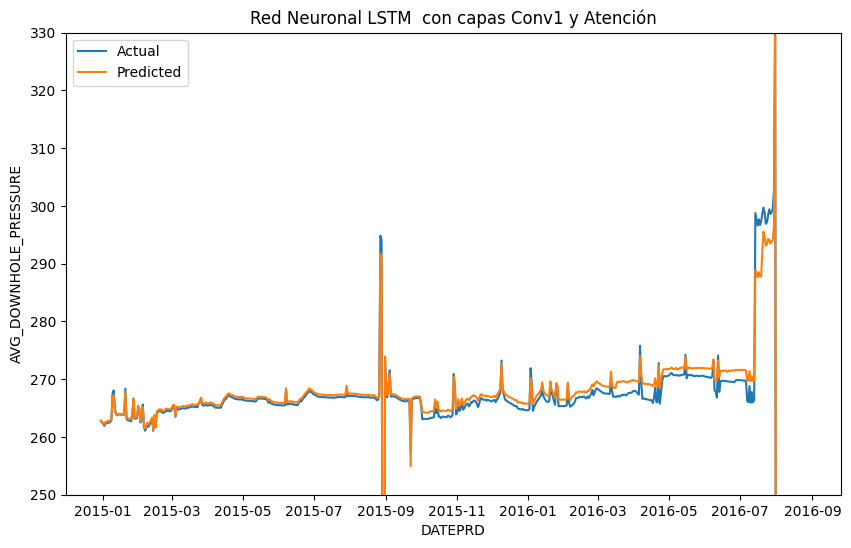

In [19]:
# Graficar los resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(results_test['Date'], results_test['Actual'], label='Actual')
plt.plot(results_test['Date'], results_test['Predicted'], label='Predicted')
plt.title('Red Neuronal LSTM  con capas Conv1 y Atención')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()
plt.ylim(250, 330)
plt.show()

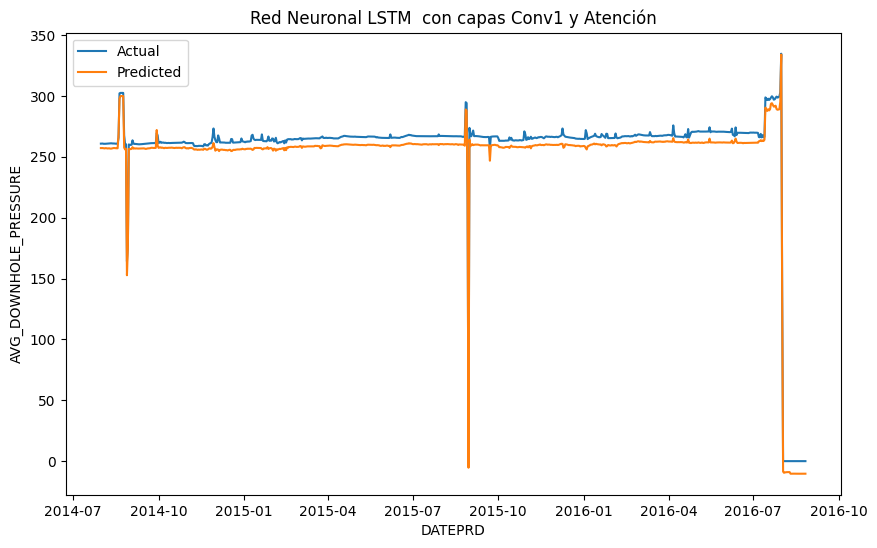

In [13]:
# Graficar los resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(results_test['Date'], results_test['Actual'], label='Actual')
plt.plot(results_test['Date'], results_test['Predicted'], label='Predicted')
plt.title('Red Neuronal LSTM  con capas Conv1 y Atención')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()
plt.show()

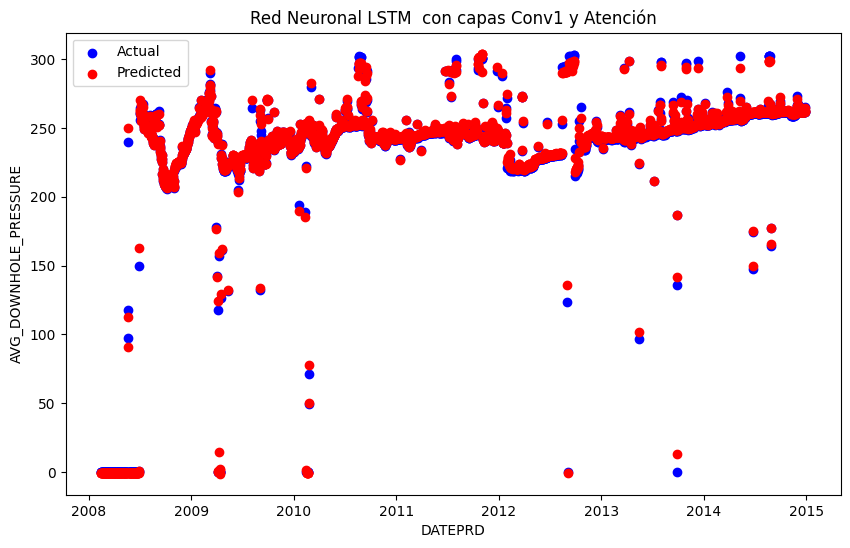

In [20]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(results_train['Date'], results_train['Actual'], label='Actual',color='Blue')
plt.scatter(results_train['Date'], results_train['Predicted'], label='Predicted', color='Red')
plt.title('Red Neuronal LSTM  con capas Conv1 y Atención')
plt.xlabel('DATEPRD')
plt.ylabel('AVG_DOWNHOLE_PRESSURE')
plt.legend()
plt.show()